# GPU Info

In [1]:
!nvidia-smi

Tue Feb 25 14:20:23 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce GTX 960M        Off |   00000000:01:00.0 Off |                  N/A |
| N/A   35C    P8             N/A /  200W |       5MiB /   4096MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# Installations

In [2]:
# !pip3 install torch torchvision torchaudio matplotlib pandas numpy torchmetrics tqdm --break-system-packages

# Imports

In [3]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader,random_split
from torch.optim import Adam, SGD, Adamax, RMSprop, AdamW

import torchvision
import torchvision.transforms as T
from torchvision.utils import make_grid

from monai.networks.nets import UNet

from PIL import Image

from tqdm import tqdm
from torchmetrics.classification import Dice

import matplotlib.pyplot as plt

from os import listdir, system, getcwd
import re
from datetime import datetime

In [4]:
torch.__version__, torchvision.__version__

('2.5.1+cu121', '0.20.1+cu121')

# Functions and Classes

In [5]:
def num_parameters(model):
    params = sum([p.numel() for p in model.parameters()])
    
    return f"Number of Parameters: {params:,}"

In [6]:
class DiceLoss(nn.Module):

    def __init__(self):
        super(DiceLoss, self).__init__()
        self.smooth = 1e-6

    def forward(self, y_pred, y_true):
        assert y_pred.size() == y_true.size()
        
        y_pred = y_pred[:, 0].flatten(1)
        y_true = y_true[:, 0].flatten(1)
        
        intersection = (y_pred * y_true).sum()
        dsc = (2. * intersection + self.smooth) / (y_pred.sum() + y_true.sum() + self.smooth)
        
        return 1. - dsc

In [7]:
class Averaging():
    def __init__(self):
        self.sum = 0.
        self.counter = 0

    def __call__(self, val: float) -> float:
        self.sum += val
        self.counter += 1

        return self.sum / self.counter

    def reset(self):
        self.sum = 0.
        self.counter = 0

In [8]:
def train_one_epoch(model, dataloader, optimizer, loss_fn, avg_fn, ep, device):
    model.train()
    avg_fn.reset()

    with tqdm(dataloader, desc=f"Epoch {ep}", unit=" batch") as trange:
        for x_batch, y_batch in trange:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)

            # Forward
            yp = model(x_batch)
            loss = loss_fn(yp, y_batch)

            # Backward
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            # Calculate the average of Dice Loss
            avg_loss = avg_fn(loss.item())
            
            trange.set_postfix(Dice_loss=loss.item())

    return model, loss.item()

In [9]:
def validate_one_epoch(model, dataloader, loss_fn, avg_fn, device):
    model.eval()
    avg_fn.reset()

    print("Plase Wait! Validation is being calculated", end='\r')

    for x_batch, y_batch in dataloader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        # Forward
        yp = model(x_batch)
        loss = loss_fn(yp, y_batch)

        # Calculate the average of Dice Loss
        avg_loss = avg_fn(loss.item())

    print(f"Valid => Dice_loss: {loss.item():.3}".ljust(55))
    
    return loss.item()

In [10]:
def plot_histories(train_loss_hist, train_acc_hist, valid_loss_hist, valid_acc_hist):
    fig, axs = plt.subplots(nrows=1, ncols=2)
    fig.set_figwidth(12)
    fig.set_figheight(4)
    fig.suptitle("Learning Curve")

    axs[0].plot(train_loss_hist, c='b', label="Train Loss")
    axs[0].plot(valid_loss_hist, c='r', label="Valid Loss")
    axs[0].set_ylabel("BCE Loss")
    
    axs[1].plot(train_acc_hist, c='b', label="Train Acc")
    axs[1].plot(valid_acc_hist, c='r', label="Valid Acc")
    axs[1].set_ylabel("Accuracy")

    for ax in axs.flatten():
        ax.set_xlabel("Epoch")
        ax.grid()
        ax.legend()

# Device and Inits

In [11]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [12]:
segment_loss_fn = DiceLoss().to(device)
avg_fn = Averaging()

# Custom Dataset <a href="https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset">Download Dataset</a>

In [13]:
class MRIDataset(Dataset):
    def __init__(self, transforms, dir_path=f"{getcwd()}/kaggle_3m"):
        self.transforms = transforms
        self.image_pattern = r".tif"
        self.mask_pattern = r"_mask"
        self.images_ls = []
        self.masks_ls = []
        self.labels = []

        self.to_tensor_transform = T.ToTensor()
        self.normalize_transform = T.Normalize(mean=0, std=1)

        patients_path = listdir(dir_path)
        
        patients_path.remove("data.csv")
        patients_path.remove("README.md")
        # patients_path.remove(".ipynb_checkpoints")

        for patient in patients_path:
            patient_images = listdir(f"{dir_path}/{patient}/")
            patient_images.sort(key=lambda x:x.replace(self.mask_pattern, ""))
            
            for img_path in patient_images:
                if re.search(self.image_pattern, img_path) is None:
                    continue
                
                if re.search(self.mask_pattern, img_path) is None:
                    self.images_ls.append(f"{dir_path}/{patient}/{img_path}")
                else:
                    mask_addr = f"{dir_path}/{patient}/{img_path}"
                    self.masks_ls.append(mask_addr)
                    pil_mask = Image.open(mask_addr)
                    self.labels.append(1 if torch.max(self.to_tensor_transform(pil_mask)) > 0 else 0)
            

    def __getitem__(self, item_idx):
        pil_img = Image.open(self.images_ls[item_idx])
        transformed_img = self.transforms(pil_img)
        
        pil_mask = Image.open(self.masks_ls[item_idx])
        transformed_mask = self.normalize_transform(self.to_tensor_transform(pil_mask))

        return transformed_img, transformed_mask
    
    def raw_item(self, item_idx):
        img = Image.open(self.images_ls[item_idx])
        mask = Image.open(self.masks_ls[item_idx])
        
        return self.to_tensor_transform(img), self.to_tensor_transform(mask), self.labels[item_idx]

    # TODO: Check the final result for each sample based on the generated mask.
    def check_result(self):
        pass
    
    def __len__(self):
        return len(self.images_ls)

# Preprocessing

## Transforms

In [14]:
img_transforms = T.Compose([
    T.RandomVerticalFlip(),
    # T.RandomRotation(60),
    T.AutoAugment(),
    T.ToTensor(),
    T.Normalize(mean=[0, 0, 0], std=[1, 1, 1])
    # T.Normalize(mean=[0.2481, 0.1816, 0.2628], std=[0.3391, 0.2814, 0.3455])
])

## Read dataset

In [15]:
dataset = MRIDataset(img_transforms, getcwd()+"/kaggle_3m")

dataset.__len__()

3929

## Visualize Random 6 Samples with Their Labels

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.3294117].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.4156862].


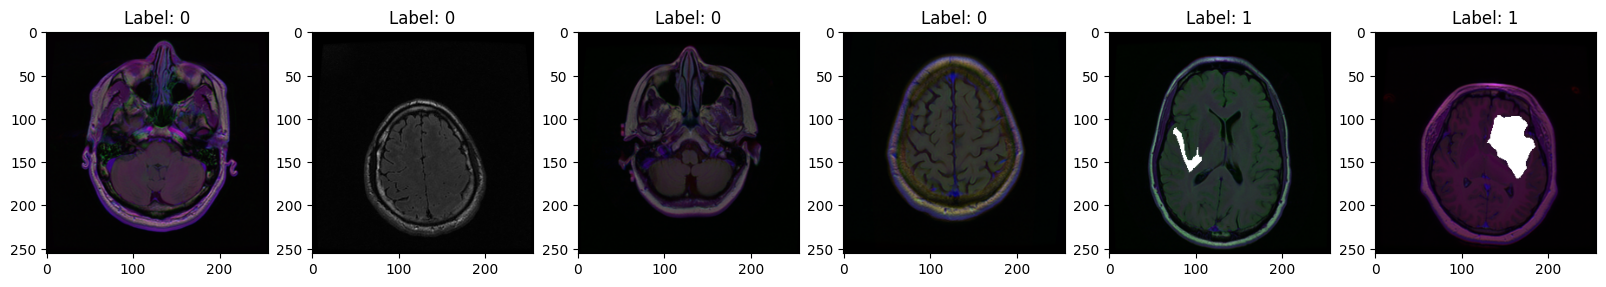

In [16]:
num_images = 6
fig, axs = plt.subplots(nrows=1, ncols=num_images)
fig.set_figwidth(20)

for idx, item_idx in enumerate(torch.randint(dataset.__len__(), (num_images,))):
    img, mask, label = dataset.raw_item(item_idx)
    img_with_mask = img + mask

    axs[idx].set_title(f"Label: {label}")
    axs[idx].imshow(img_with_mask.permute(1, 2, 0))

## Labels Distribution

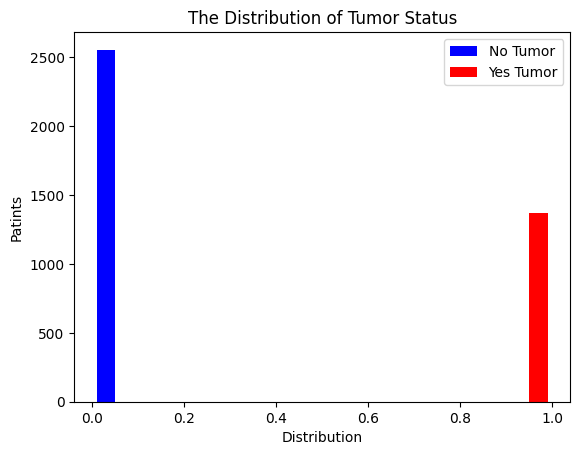

In [17]:
labels = dataset.labels
no_tumor = list(filter(lambda x: x == 0, labels))
yes_tumor = list(filter(lambda x: x == 1, labels))

plt.hist([no_tumor, yes_tumor], label=["No Tumor", "Yes Tumor"], color=["blue", "red"]);
plt.xlabel("Distribution")
plt.ylabel("Patints")
plt.title("The Distribution of Tumor Status")

plt.legend();

## Split Train, Valid, Test sets

In [18]:
train_set, valid_set, test_set = random_split(dataset, [0.7, 0.2, 0.1])

len(train_set.indices), len(valid_set.indices), len(test_set.indices)

(2751, 786, 392)

## Make Dataloader

In [19]:
train_loader = DataLoader(train_set, batch_size=16, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=14)
test_loader = DataLoader(test_set, batch_size=32)

In [20]:
img, label = next(iter(train_loader))

img.shape, label.shape

(torch.Size([16, 3, 256, 256]), torch.Size([16, 1, 256, 256]))

# U-Net Model

In [21]:
class UNetModel(nn.Module):
    def __init__(self, unet_size="medium", input_channel=3, num_cls=1):
        super().__init__()

        assert unet_size in ["small", "medium", "large"]
        
        i, j = 0, 0

        if unet_size == "small":
            conv_channels = [input_channel] + [16, 32, 64, 128, 256]
        elif unet_size == "medium":
            conv_channels = [input_channel] + [32, 64, 128, 256, 512]
        else:
            conv_channels = [input_channel] + [64, 128, 256, 512, 1024]
        
        conv_channels_len = len(conv_channels)
        self.conv_ls = nn.ModuleDict()
        self.concat_idx = []
        
        # Encoder
        for channel_idx in range(1, conv_channels_len):
            self.conv_ls[f"conv_{j}"] = self.normal_convolution(conv_channels[channel_idx-1], conv_channels[channel_idx])
            self.conv_ls[f"save_conv_{i}"] = self.normal_convolution(conv_channels[channel_idx], conv_channels[channel_idx])

            # The Stride of the MaxPool must be equal 2 to exactly halve the height and width of the image
            if channel_idx != conv_channels_len-1:
                self.conv_ls[f"max_pool_{i}"] = nn.MaxPool2d(2, 2, 1, return_indices=True)
    
            i += 1
            j += 1

        i = 0
        
        # Decoder
        for channel_idx in range(conv_channels_len-1, 1, -1):
            self.conv_ls[f"up_conv_{i}"] = self.up_convolution(conv_channels[channel_idx], conv_channels[channel_idx-1])
            self.conv_ls[f"max_unpool_{i}"] = nn.MaxUnpool2d(3, 2, 1)
            
            self.conv_ls[f"concat_conv_{i}"] = self.normal_convolution(conv_channels[channel_idx], conv_channels[channel_idx-1])

            # The last layer (Classifier layer)
            if channel_idx == 2:
                self.conv_ls[f"conv_{j}"] = nn.Conv2d(conv_channels[channel_idx-1], num_cls, kernel_size=1)
                continue
            
            self.conv_ls[f"conv_{j}"] = self.normal_convolution(conv_channels[channel_idx-1], conv_channels[channel_idx-1])
            i += 1
            j += 1
            
    def __repr__(self):
        print(self.conv_ls)
        
        return "U-Net()"
    
    def normal_convolution(self, in_channels, out_channels, kernel=3, stride=1, padding=1):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel, stride, padding),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )
        
    def up_convolution(self, in_channels, out_channels, kernel=3, stride=1, padding=1):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel, stride, padding),
            # nn.BatchNorm2d(out_channels),
            # nn.LeakyReLU(),
        )
    
    def forward(self, y: torch.Tensor):
        concatenation_ls, max_pool_indeces = [], []

        for layer_name in self.conv_ls.keys():
            layer = self.conv_ls[layer_name]
            
            if re.search(r"max_pool_*", layer_name):
                y, indeces = layer(y)
                max_pool_indeces.append(indeces)

            elif re.search(r"max_unpool_*", layer_name):
                concat = concatenation_ls.pop()
                concatenation_ls.append(concat)
                y = layer(y, max_pool_indeces.pop(), output_size=concat.shape)

            elif re.search(r"save_conv_[0-3]$", layer_name):
                y = layer(y)
                concatenation_ls.append(y)
                
            elif re.search(r"concat_conv_*", layer_name):
                concat = concatenation_ls.pop()
                y = torch.concat((concat, y), dim=1)
                y = layer(y)

            else:
                y = layer(y)

        return torch.sigmoid(y)

In [21]:
model = UNetModel()
num_parameters(model)

'Number of Parameters: 8,627,073'

# Check Paths

## Forward

In [22]:
with torch.no_grad():
    model = UNetModel().to(device)

    x_batch, y_batch = next(iter(train_loader))
    x_batch, y_batch = x_batch.to(device), y_batch.to(device)
    
    yp = model(x_batch)
    loss = segment_loss_fn(yp, y_batch)

torch.cuda.empty_cache()

loss.item()

0.9921454191207886

## Backward

In [24]:
mini_percentage = 0.2

_, mini_dataset = random_split(dataset, [1-mini_percentage, mini_percentage])
mini_dataloader = DataLoader(mini_dataset, batch_size=8, shuffle=True)

In [25]:
model = UNetModel().to(device)
# model = UNet(2, 3, 1, [64, 128, 512, 1024], [2, 2, 2, 2]).to(device)
# optimizer = RMSprop(model.parameters(), lr=1e-04, weight_decay=1e-5, momentum=0.9)
optimizer = Adam(model.parameters(), lr=1e-04)

for ep in range(4):
    model, _ = train_one_epoch(model, mini_dataloader, optimizer, segment_loss_fn, avg_fn, ep, device)
    validate_one_epoch(model, mini_dataloader, segment_loss_fn, avg_fn, device)
    
torch.cuda.empty_cache()

Epoch 0: 100%|█████████████████████████████████████████████████████████████████████████| 99/99 [01:48<00:00,  1.10s/ batch, Dice_loss=1]


Valid => Dice_loss: 1.0                                


Epoch 1: 100%|█████████████████████████████████████████████████████████████████████████| 99/99 [01:50<00:00,  1.12s/ batch, Dice_loss=1]


Valid => Dice_loss: 1.0                                


Epoch 2: 100%|█████████████████████████████████████████████████████████████████████████| 99/99 [01:56<00:00,  1.17s/ batch, Dice_loss=1]


Valid => Dice_loss: 1.0                                


Epoch 3: 100%|█████████████████████████████████████████████████████████████████████████| 99/99 [01:50<00:00,  1.12s/ batch, Dice_loss=1]


Valid => Dice_loss: 0.999                              


# Find Efficient Hyper-Parameters

In [ ]:
start_time = datetime.now().replace(microsecond=0)

for lr in [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]:
    model = UNetModel("small").to(device)
    optimizer = RMSprop(model.parameters(), lr=lr, weight_decay=1e-4, momentum=0.9)
    
    print(f"\nlr: {lr}")
    for ep in range(3):
        model, _ = train_one_epoch(model, train_loader, optimizer, segment_loss_fn, avg_fn, ep, device)
        validate_one_epoch(model, valid_loader, segment_loss_fn, avg_fn, device)
        
    torch.cuda.empty_cache()

end_time = datetime.now().replace(microsecond=0)

print(f"\nRun Time: {end_time-start_time}")

# Full Train

In [ ]:
model = UNetModel("large").to(device)
optimizer = RMSprop(model.parameters(), lr=1e-04, weight_decay=1e-5, momentum=0.9)
# optimizer = AdamW(model.parameters(), lr=1e-04, weight_decay=1e-5)
# optimizer = Adam(model.parameters(), lr=1e-05)

best_valid_loss = 2
final_model = None

num_parameters(model)

In [ ]:
train_loss_hist, valid_loss_hist = [], []

In [ ]:
start_time = datetime.now().replace(microsecond=0)

for ep in range(30):
    model, train_loss = train_one_epoch(model, train_loader, optimizer, segment_loss_fn, avg_fn, ep, device)
    valid_loss = validate_one_epoch(model, valid_loader, segment_loss_fn, avg_fn, device)

    if best_valid_loss > valid_loss:
        final_model = model
        best_valid_loss = valid_loss

    train_loss_hist.append(train_loss)
    valid_loss_hist.append(valid_loss)

torch.cuda.empty_cache()

end_time = datetime.now().replace(microsecond=0)

print(f"\nRun Time: {end_time-start_time}")

# Learning Curve

In [ ]:
plot_histories(train_loss_hist, [], valid_loss_hist, []);

# Save the Trained Model

In [ ]:
torch.save(final_model, "./final_model.pt")

# Testing Phase

In [27]:
final_model_loaded = torch.load("final_model_30_ep.pt", weights_only=False).to(device)
num_parameters(final_model_loaded)

'Number of Parameters: 34,489,985'

In [ ]:
start_time = datetime.now().replace(microsecond=0)

with torch.inference_mode():
    test_loss = validate_one_epoch(final_model_loaded, test_loader, segment_loss_fn, avg_fn, device)
    
    torch.cuda.empty_cache()

end_time = datetime.now().replace(microsecond=0)

print(f"\nRun Time: {end_time-start_time}")

In [ ]:
test_iter = iter(test_loader)

In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=2)
fig.set_figwidth(15)

with torch.inference_mode():
    img, mask = next(test_iter)
    img = img.to(device)
    
    yp = final_model_loaded(img)

    torch.cuda.empty_cache()

yp = yp.to("cpu")
img = img.to("cpu")

grid_img = make_grid(img, nrow=8, pad_value=4, normalize=True).permute(1, 2, 0)
grid_mask = make_grid(mask, nrow=8, pad_value=4, normalize=True).permute(1, 2, 0)
grid_yp = make_grid(yp, nrow=8, pad_value=4, normalize=True).permute(1, 2, 0)
grid_mix = make_grid(yp+mask, nrow=8, pad_value=4, normalize=True).permute(1, 2, 0)

axs[0][0].imshow(grid_img)
axs[0][0].set_title("Images")

axs[0][1].imshow(grid_mask)
axs[0][1].set_title("Mask")

axs[1][0].imshow(grid_yp)
axs[1][0].set_title("yp")

axs[1][1].imshow(grid_mix)
axs[1][1].set_title("yp + mask")

# Check Weights

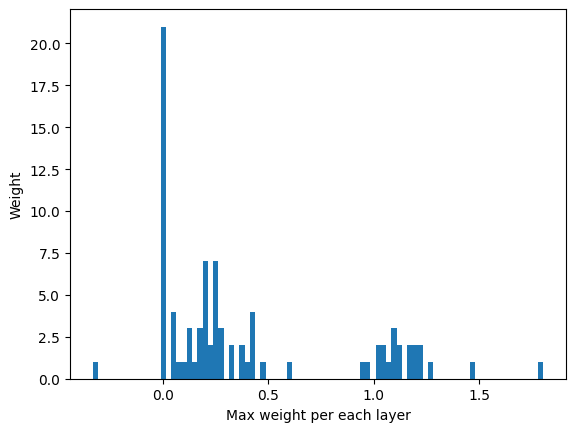

In [98]:
final_model_loaded = torch.load("final_model_30_ep.pt", weights_only=False).to(device)
num_parameters(final_model_loaded)

grads = []

for w in final_model_loaded.parameters():
    grads.append(torch.max(w).item())

plt.hist(grads, bins=len(grads))
plt.xlabel("Max weight per each layer");
plt.ylabel("Weight");